# 1. Import libraries

In [72]:
# Import necessary libraries
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns

from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.preprocessing.image import DirectoryIterator

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
# From here, add any libraries that you might need for the rest of your code
# Check if running in Google Colab
try:
    from google.colab import drive
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# Mount Google Drive if in Google Colab
if IN_COLAB:
    drive.mount('/content/drive', force_remount=True)  # Mounts Google Drive for each user in Colab
    print("Google Drive mounted successfully in Colab.")

else:
    # If running in a local Jupyter Notebook, ensure the necessary path is set
    print("Running outside Google Colab. Please ensure necessary paths are correctly set in Jupyter Notebook.")


Running outside Google Colab. Please ensure necessary paths are correctly set in Jupyter Notebook.


# 2. Load and pre-process the dataset

In [73]:
# Set the paths based on your Drive directory
data_dir ='D:\T' # Change to the path to your directory

train_images_dir = os.path.join(data_dir, 'Training')
test_images_dir = os.path.join(data_dir, 'Testing')

print(f"Data directory: {data_dir}")
print(f"Training directory: {train_images_dir}")
print(f"Testing directory: {test_images_dir}")

Data directory: D:\T
Training directory: D:\T\Training
Testing directory: D:\T\Testing


*   This code loads images from directories, adds noise to them, rescales them, and prepares them for training/testing
*   Training data is shuffled and processed in batches of 32 images.
    *   Shuffle for Training: Helps the model generalize by presenting the data in a different order, reducing the risk of model overfitting or learning the order of the data.
    *   No shuffle for Testing: It keeps the test data in the same order, so the evaluation is consistent and reliable.

*   The images are resized to 30x30 pixels, and their pixel values are normalized between 0 and 1.
*   Classes are one-hot encoded, which is important for multi-class classification problems.





In [74]:
## IMPORTANT: please remember that you are not allowed to change the
## loading and preprocessing code to improve model performance for this assignment.

# Load and preprocess the data
# add_noise : To add random Gaussian noise to each image, which can help the model generalize better by preventing it from memorizing training data
np.random.seed(seed=42)
def add_noise(img):
    std_coeff = 70*np.random.random()
    noise = np.random.normal(0, std_coeff, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

image_res = 30 # resized to 30x30 pixels for processing
def get_images(train_dir: str, test_dir: str):
    datagen = ImageDataGenerator(rescale=1./255, # Rescales image pixel values from [0,255] to [0,1]
                                 preprocessing_function=add_noise)

    img_height, img_width = image_res, image_res
    batch_size = 32

    # Load training data
    train_data = datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width), # Resizes every image to 30x30 pixels
        batch_size=batch_size, # Loads 32 images at a time
        class_mode='categorical', # One-hot encoding happens here
        shuffle=True,
        color_mode='grayscale' # they only have one color channel(insted of three for RGB)
    )

    # Load test data
    test_data = datagen.flow_from_directory(
        test_dir,
        target_size=(img_height, img_width), # Resizes every image to 30x30 pixels
        batch_size=batch_size, # Loads 32 images at a time
        class_mode='categorical', # One-hot encoding happens here
        shuffle=False,
        color_mode='grayscale' # they only have one color channel(insted of three for RGB)
    )

    return train_data, test_data

# Load the training and test data
try:
    train_data, test_data = get_images(train_images_dir, test_images_dir)
    print("Data loading completed successfully.")
    print(f"Number of training samples: {train_data.samples}")
    print(f"Number of test samples: {test_data.samples}")
    print(f"Class names: {train_data.class_indices}")
except Exception as e:
    print(f"Error loading data: {e}")
    raise

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Data loading completed successfully.
Number of training samples: 5712
Number of test samples: 1311
Class names: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


# 3. Visualise data and plot data distribution

*   Visualise random 15 samples from the dataset. Image should be displayed with its corresponding label as text on top of the image.

***The issue with the images not appearing clearly when using this function would be several factors:
     1. Resize to 30x30 pixels
     2. Add_noise function





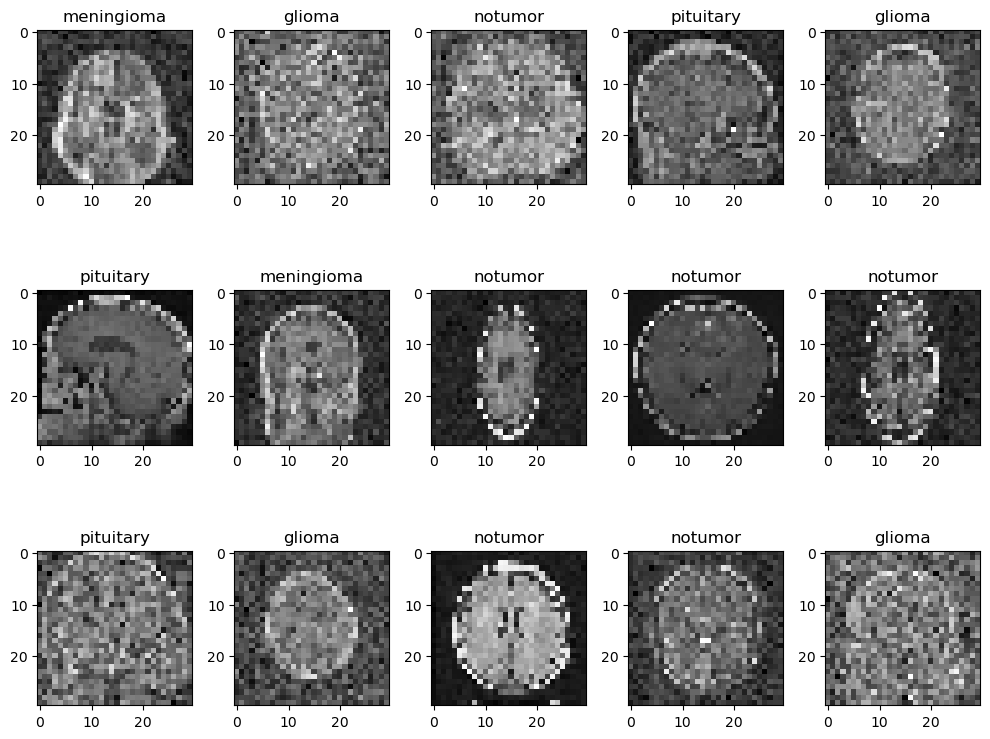

In [75]:
# Function to display 15 random samples from the dataset
def display_random_samples(data_gen, num_samples=15):
    images, labels = next(data_gen)  # Get one batch of images
    indices = random.sample(range(len(images)), num_samples)  # Randomly select 15 images

    plt.figure(figsize=(10, 8))
    for i, idx in enumerate(indices):
        plt.subplot(3, 5, i+1)  # Arrange in a grid 3x5
        img = images[idx].squeeze()  # Squeeze to remove any singleton dimensions (if grayscale)
        plt.imshow(img, cmap='gray')  # Assuming grayscale
        label_idx = np.argmax(labels[idx])  # Get the class label index
        class_label = [k for k, v in train_data.class_indices.items() if v == label_idx][0]
        plt.title(class_label)
    plt.tight_layout()
    plt.show()

# Call the function to display 15 random samples from the training data
display_random_samples(train_data)

*   Create a bar plot to visulaize the class label distribution of the dataset




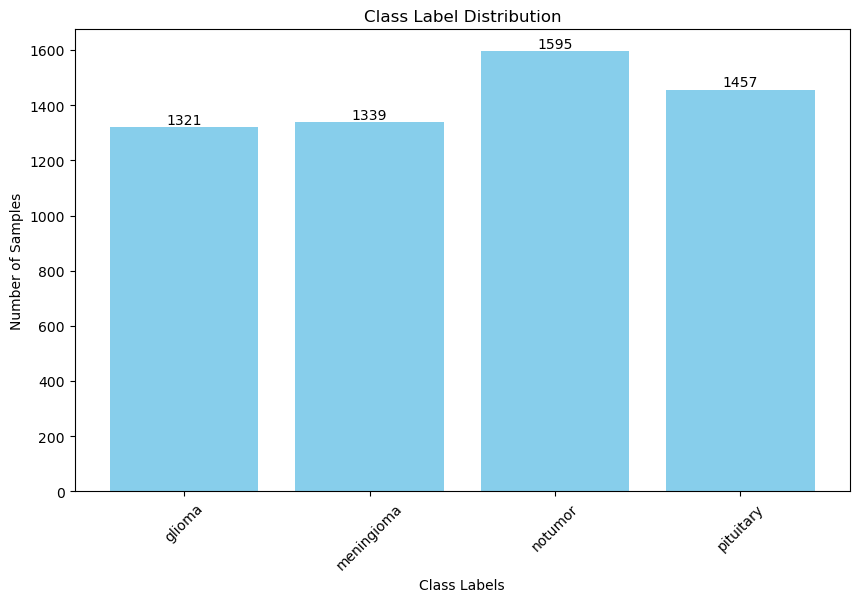

In [76]:
# Create a bar plot to visualize the class label distribution
def plot_class_distribution(data_gen):
    class_labels = list(data_gen.class_indices.keys())  # Get class labels
    num_samples = list(data_gen.classes)  # List of classes for all samples
    class_count = np.bincount(num_samples)  # Count of each class

    plt.figure(figsize=(10, 6))
    bars = plt.bar(class_labels, class_count, color='skyblue')

    plt.xlabel('Class Labels')
    plt.ylabel('Number of Samples')
    plt.title('Class Label Distribution')
    plt.xticks(rotation=45)

    # Add the total number on top of each bar
    for bar, count in zip(bars, class_count):
        yval = bar.get_height()  # Height of the bar (number of samples)
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{int(count)}', ha='center', va='bottom')

    plt.show()

# Call the function to create the class distribution plot
plot_class_distribution(train_data)


# 4. Train and Evaluation functions

*   Implement the baseline CNN algorithm without any modification for both model and dataset.

  1.   Convolutional layer with 32 filters and kernel size of 3 x 3 with ReLU activations followed by a max pooling layer of size 2 x 2
  2.   Convolutional layer with 32 filters and kernel size of 3 x 3 with ReLu activations followed by a max pooling layer of size 2 x 2
  3.   Flatten the 3D output
  4.   Desn layers of sizes 32 and with Relu activation
  5.   Output layer with softmax activation are added for multi-class classification
  6. The optimizer should be Adam, metric should be acrruracy. The categorical crossentropy loss function is used for multi-class classification problems.







In [77]:
# CNN to classify grayscale images (30x30pixels) into different categories.
# Correct input shape for grayscale images (30x30 pixels, 1 channel)
img_shape = (30, 30, 1)  # 30x30 pixels, 1 channel (grayscale)
model = models.Sequential()

# first convolutional layer + max pooling layer
model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = img_shape)) #relu helps to introduce non-linearity
model.add(layers.MaxPooling2D((2,2)))

# second convolutional layer + max pooling layer
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# flatten the 3D output from the convolutional layers into 1D
model.add(layers.Flatten())

# Dense layer with 32 units and ReLU activation
model.add(layers.Dense(32, activation = 'relu'))

num_classes = len(list(train_data.class_indices.keys()))
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Loss function for multi-class classification
              metrics=['accuracy'])

# Summary of the model
model.summary()

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_89 (Conv2D)                   │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_89 (MaxPooling2D)      │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_90 (Conv2D)                   │ (None, 12, 12, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_90 (MaxPooling2D)      │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_45 (Flatten)                 │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_135 (Dense)                    │ (None, 32)                  │          36,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_136 (Dense)                    │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,596 (182.02 KB)

 Trainable params: 46,596 (182.02 KB)

 Non-trainable params: 0 (0.00 B)

*   Analyze the performance of the baseline by plotting
  1.   **Split the training data and validation data again due to the restriction of not modifying the preprocessing code.**
      
      -> Given that it's not allowed to modify the original preprocessing code and it's already loaded train_data and test_data using the ImageDataGenerator, we need a solution that follows the rule but still allows you to create a validation set from the training data.

      Since we're using ImageDataGenerator to load both the training and test data, the easiest way to create a validation set without modifying the original code is to split the training data after loading it.
  2.   The training and validation losses and accuracies on the training and validation set through epochs
  3.   The Receiver Operator Characteristic (ROC) curve with the Area under the Curve (AUC) score and a confusion matrix for the validation and test sets.
  4.   Report performance measures (accuracy, precision, recall, and F1-score) for both validation and test sets.






In [78]:
# Collect all images and labels from the train_data generator
x_data = []
y_data = []

# Loop through the generator to collect data
for i in range(len(train_data)):
    images, labels = next(train_data)
    x_data.extend(images)
    y_data.extend(labels)

# Convert lists to NumPy arrays
x_data = np.array(x_data)
y_data = np.array(y_data)

# Split into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

# Now you can use x_train, y_train for training and x_val, y_val for validation.
print("Split the training and validation data successfully.")
print(f"Number of training samples: {len(x_train)}")  # Should show 80% of total
print(f"Number of validation samples: {len(x_val)}")  # Should show 20% of total
print(f"Number of validation samples: {test_data.samples}")


Split the training and validation data successfully.
Number of training samples: 4569
Number of validation samples: 1143
Number of validation samples: 1311


In [79]:
validation_data=(x_val, y_val)

In [80]:
# Train the model with NumPy arrays
history = model.fit(
    x_train,  # Training data (images)
    y_train,  # Training data (labels)
    validation_data=(x_val, y_val),  # Validation data (images and labels)
    epochs=10,
    shuffle=True
)

Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.3856 - loss: 1.2553 - val_accuracy: 0.6842 - val_loss: 0.8430
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6893 - loss: 0.8073 - val_accuracy: 0.7279 - val_loss: 0.7001
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7548 - loss: 0.6640 - val_accuracy: 0.7349 - val_loss: 0.6891
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7569 - loss: 0.6232 - val_accuracy: 0.7629 - val_loss: 0.6077
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7951 - loss: 0.5556 - val_accuracy: 0.7822 - val_loss: 0.5668
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7933 - loss: 0.5395 - val_accuracy: 0.7638 - val_loss: 0.5811
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8023 - loss: 0.5061 - val_accuracy: 0.7734 - val_loss: 0.5412
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8224 - loss: 0.4769 - val_accuracy: 

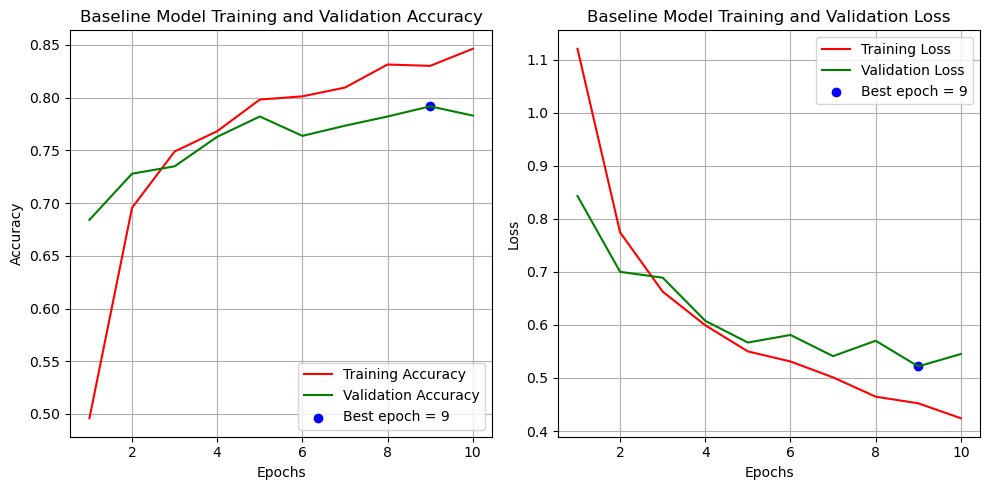

In [81]:
# Assuming 'history' is the variable that holds the result of model.fit()
np.random.seed(42)

def plot_training_history(history):
    epochs = range(1, len(history.history['accuracy']) + 1)

    # Plot training and validation accuracy
    plt.figure(figsize=(10, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], 'r', label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], 'g', label='Validation Accuracy')
    plt.title('Baseline Model Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Highlight the best epoch for validation accuracy
    best_epoch_acc = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1
    plt.scatter(best_epoch_acc, max(history.history['val_accuracy']), label=f'Best epoch = {best_epoch_acc}', color='blue')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], 'r', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'g', label='Validation Loss')
    plt.title('Baseline Model Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Highlight the best epoch for validation loss based on the best validation accuracy epoch
    plt.scatter(best_epoch_acc, history.history['val_loss'][best_epoch_acc - 1], label=f'Best epoch = {best_epoch_acc}', color='blue')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function with the history object returned from model.fit()
plot_training_history(history)

In [82]:
# Create a tensorFlow Dataset for your validation data
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(32)  # Set batch size to match other data generators


In [83]:
def plot_multiclass_roc_and_confusion_matrix(model, data_gen, class_names, set_type='Validation'):
    y_true = []
    y_pred = []

    # Check if data_gen is a TensorFlow Dataset object or a generator
    if isinstance(data_gen, tf.data.Dataset):
        # Collect true labels and predicted probabilities from Dataset
        for images, labels in data_gen:
            preds = model.predict(images)
            y_true.extend(np.argmax(labels, axis=1))
            y_pred.extend(preds)
    else:
        # Collect true labels and predicted probabilities from generator
        for images, labels in data_gen:
            preds = model.predict(images)
            y_true.extend(np.argmax(labels, axis=1))
            y_pred.extend(preds)
            if len(y_true) >= data_gen.samples:
                break

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Binarize the output for ROC calculations
    y_true_binarized = label_binarize(y_true, classes=[0, 1, 2, 3])
    n_classes = y_true_binarized.shape[1]

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC and Confusion Matrix
    plt.figure(figsize=(10, 5))

    # Plot ROC curve
    plt.subplot(1, 2, 1)
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {set_type} Set')
    plt.legend(loc="lower right")

    # Plot Confusion Matrix
    plt.subplot(1, 2, 2)
    y_pred_classes = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_true, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix for {set_type} Set')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━

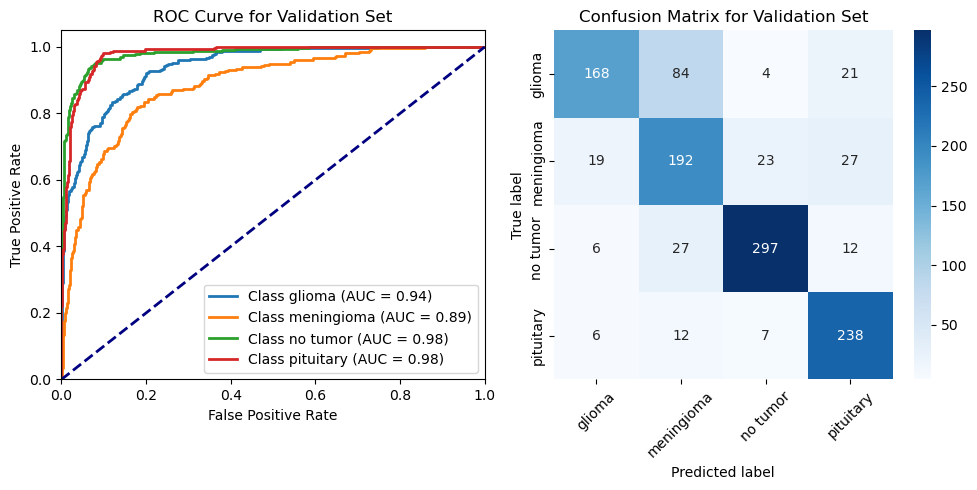

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

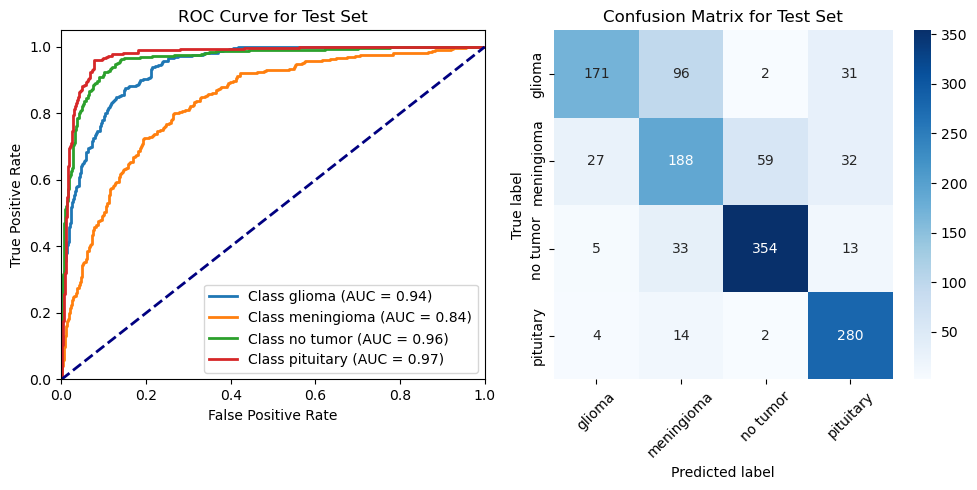

In [84]:
# Define the class names corresponding to your data
class_names = ['glioma', 'meningioma', 'no tumor', 'pituitary']


# Example usage for the validation set using the custom Dataset
plot_multiclass_roc_and_confusion_matrix(model, val_dataset, class_names, set_type='Validation')

# Example usage for the test set using the DirectoryIterator
plot_multiclass_roc_and_confusion_matrix(model, test_data, class_names, set_type='Test')


# 6. Model Optimization

## 6.1 Get insight from Loops of parameters

### 6.1.1 Define functions that creates models with varying configurations 

Here we add the optimization phase with the hyperparameters mentioned below to the baseline model:
- Filter size
- Number of filters
- Number of layers
- Number of units in dense layers
- Hidden layer activation function
- Padding
- Stride
- Epochs
- Batch size
- Optimizers (Adagrad, RMSprop, Adam, SGD)

In [85]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adagrad, RMSprop, Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2

# Function to create the model with configurable parameters
from tensorflow.keras.regularizers import l1, l2, l1_l2

def create_model(filter_size=(3, 3), num_filters=32, num_layers=2, num_units=64,
                 activation='relu', padding='same', stride=(1, 1), 
                 l1_lambda=0.0, l2_lambda=0.0,dropout_rate=0.0, input_shape=(30, 30, 1), num_classes=4):
    
    
    model = Sequential()
    
    # Determine the regularizer
    if l1_lambda > 0 and l2_lambda > 0:
        regularizer = l1_l2(l1=l1_lambda, l2=l2_lambda)
    elif l1_lambda > 0:
        regularizer = l1(l1_lambda)
    elif l2_lambda > 0:
        regularizer = l2(l2_lambda)
    else:
        regularizer = None

    # Adding convolutional layers
    for i in range(num_layers):
        model.add(Conv2D(filters=num_filters, kernel_size=filter_size, activation=activation,
                         padding=padding, strides=stride, input_shape=input_shape if i == 0 else None,
                         kernel_regularizer=regularizer))
        model.add(MaxPooling2D(pool_size=(2, 2)))
#   model.add(BatchNormalization())

    # Flatten and add Dense layers
    model.add(Flatten())
    model.add(Dense(num_units, activation=activation, kernel_regularizer=regularizer))
    model.add(Dense(num_units, activation=activation, kernel_regularizer=regularizer))
    model.add(Dropout(dropout_rate))
    
    # Output layer (assuming 10 classes)
    model.add(Dense(num_classes, activation='softmax'))
    
    return model



In [86]:
def train_and_evaluate(filter_size, num_filters, num_layers, num_units, activation, padding, stride, 
                       optimizer_name, l1_lambda, l2_lambda, dropout_rate, epochs, batch_size, num_classes):
    
  
    # Create the model
    model = create_model(filter_size=filter_size, num_filters=num_filters, num_layers=num_layers, 
                         num_units=num_units, activation=activation, padding=padding, stride=stride, 
                         l1_lambda=l1_lambda, l2_lambda=l2_lambda, dropout_rate=dropout_rate, num_classes=num_classes)
    
 
    # Instantiate a new optimizer for each training run
    if optimizer_name == 'adagrad':
        optimizer = Adagrad()
    elif optimizer_name == 'rmsprop':
        optimizer = RMSprop()
    elif optimizer_name == 'adam':
        optimizer = Adam()
    elif optimizer_name == 'sgd':
        optimizer = SGD() 
        
    # Compile the model with the selected optimizer
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Using early stopping
#     early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # Train the model
    history = model.fit(train_data, validation_data=validation_data, epochs=epochs, 
                        batch_size=batch_size) #, callbacks=[early_stopping]
    
    return history.history


Here we are defining experiments with different settings (Combination of parameters).

This code performs a grid search over the specified parameter space using simple loops.
We can adjust the search space by modifying the lists provided for each hyperparameter.

In [87]:
# Define the ranges of parameters to be tested
filter_sizes = [(3, 3) , (5,5)]  # using diffrent filter size
num_filters_list = [32 , 64]   # using diffrent number of filters
num_layers_list = [2]          # using 2 layer CNN (Conv2D + Max pooling)
num_units_list = [32 , 64]     # using diffrent number of units in Dense layers
activations = ['relu', 'tanh'] # using diffrent activation function in layers
paddings = ['valid']    # using diffrent padding
strides = [(1,1)]      # using diffrent strides
epochs_list = [10]             # using sufficient epochs
batch_sizes = [32]          # using diffrent batch_sizes
optimizers = {'rmsprop': RMSprop(), 'adagrad': Adagrad(), 'adam':Adam(), 'sgd':SGD()} # using diffrent Optimizer
l1_lambdas = [0]
l2_lambdas = [0] 
dropout_rates = [0]

# batch normalization
# Early stoping

results = []

# Iterate over all combinations
for filter_size in filter_sizes:
    for num_filters in num_filters_list:
        for num_layers in num_layers_list:
            for num_units in num_units_list:
                for activation in activations:
                    for padding in paddings:
                        for stride in strides:
                            for opt_name in optimizers.keys():  # Use keys instead of values
                                for l1_lambda in l1_lambdas:
                                    for l2_lambda in l2_lambdas:
                                        for dropout_rate in dropout_rates:
                                            for epochs in epochs_list:
                                                for batch_size in batch_sizes:
                                                    print(f"Training model with config: filter_size={filter_size}, num_filters={num_filters}, "
                                                          f"num_layers={num_layers}, num_units={num_units}, activation={activation}, padding={padding}, "
                                                          f"stride={stride}, optimizer={opt_name}, l1_lambda={l1_lambda}, l2_lambda={l2_lambda}, "
                                                          f"dropout_rate={dropout_rate}, epochs={epochs}, batch_size={batch_size}")
                                                    
                                                    # Train and evaluate the model
                                                    history = train_and_evaluate(filter_size, num_filters, num_layers, num_units, activation, 
                                                                                 padding, stride, opt_name, l1_lambda, l2_lambda, dropout_rate, 
                                                                                 epochs, batch_size, num_classes)
                                                    
                                                    # Store the results
                                                    result = {
                                                        'filter_size': filter_size,
                                                        'num_filters': num_filters,
                                                        'num_layers': num_layers,
                                                        'num_units': num_units,
                                                        'activation': activation,
                                                        'padding': padding,
                                                        'stride': stride,
                                                        'optimizer': opt_name,
                                                        'l1_lambda': l1_lambda,
                                                        'l2_lambda': l2_lambda,
                                                        'dropout_rate': dropout_rate,
                                                        'epochs': epochs,
                                                        'batch_size': batch_size,
                                                        'history': history
                                                    }
                                                    results.append(result)

Training model with config: filter_size=(3, 3), num_filters=32, num_layers=2, num_units=32, activation=relu, padding=valid, stride=(1, 1), optimizer=rmsprop, l1_lambda=0, l2_lambda=0, dropout_rate=0, epochs=10, batch_size=32


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 17s 86ms/step - accuracy: 0.4785 - loss: 1.1656 - val_accuracy: 0.7262 - val_loss: 0.7486
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - accuracy: 0.7058 - loss: 0.7693 - val_accuracy: 0.7472 - val_loss: 0.6613
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.7266 - loss: 0.6716 - val_accuracy: 0.7787 - val_loss: 0.5457
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.7629 - loss: 0.5873 - val_accuracy: 0.7839 - val_loss: 0.5268
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.7840 - loss: 0.5570 - val_accuracy: 0.7927 - val_loss: 0.5184
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.7910 - loss: 0.5247 - val_accuracy: 0.8276 - val_loss: 0.4288
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - accuracy: 0.8063 - loss: 0.4933 - val_accuracy: 0.8101 - val_loss: 0.4996
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.8194 - loss: 0.4739 - val_accurac

### 6.1.2 Visualizing the Results of varying configurations

To visually compare the results from the different configurations, We provided code to generate graphs for the key metrics ( training accuracy, validation accuracy). This will help to evaluate the impact of various hyperparameters on model performance.

In [88]:
import pickle

# Update the path to a location on your local machine
save_path = 'model_comparison_results.pkl'  # Saves in the current working directory

# Save the results to a file for later analysis
with open(save_path, 'wb') as f:
    pickle.dump(results, f)

# Replace 'your_results_file.pkl' with the path to your pickle file
with open('model_comparison_results.pkl', 'rb') as f:
    results = pickle.load(f)

In [89]:
import pandas as pd

# Create a DataFrame from the loaded results
records = []
for result in results:
    record = {
        'filter_size': result['filter_size'],
        'num_filters': result['num_filters'],
        'num_layers': result['num_layers'],
        'num_units': result['num_units'],
        'activation': result['activation'],
        'padding': result['padding'],
        'stride': result['stride'],
        'optimizer': result['optimizer'],
        'l1_lambda': result['l1_lambda'],
        'l2_lambda': result['l2_lambda'],
        'dropout_rate': result['dropout_rate'],
        'epochs': result['epochs'],
        'batch_size': result['batch_size'],
        'train_accuracy': max(result['history']['accuracy']),
        'val_accuracy': max(result['history']['val_accuracy']),
        'train_loss': min(result['history']['loss']),
        'val_loss': min(result['history']['val_loss']),
    }
    records.append(record)

results_df = pd.DataFrame(records)


In [90]:
import plotly.express as px

# Create an interactive scatter plot for training vs validation accuracy
fig = px.scatter(
    results_df, 
    x='train_accuracy', 
    y='val_accuracy', 
    color='optimizer',  # Color by optimizer to differentiate
    hover_data=['filter_size', 'num_filters', 'num_layers', 'num_units', 
                'activation', 'padding', 'stride', 'l1_lambda', 'l2_lambda', 
                'dropout_rate', 'epochs', 'batch_size'],  # Display parameter details
    title='Training vs Validation Accuracy for Different Optimizers',
    labels={'train_accuracy': 'Training Accuracy', 'val_accuracy': 'Validation Accuracy'},
    size='train_accuracy',  # Change the size based on a column, you can replace with any column in your data,
    size_max=10,  # Adjust this value to make bubbles larger or smaller (default is 20)
)

fig.show()


In [92]:
import plotly.express as px

# Create an interactive scatter plot for training vs validation accuracy
fig = px.scatter(
    results_df, 
    x='train_accuracy', 
    y='val_accuracy', 
    color='optimizer',  # Differentiating by optimizer
    symbol='num_filters',  # Differentiating by num_filters function
    facet_col='num_units',  # Differentiating by num_units
    facet_row='activation',   # Differentiating by activation
    hover_data=['filter_size', 'num_filters', 'num_layers', 'num_units', 
                'activation', 'padding', 'stride'],  # Display parameter details
    title='',
    labels={'train_accuracy': 'Training Accuracy', 'val_accuracy': 'Validation Accuracy'},
    size='train_accuracy',  # Adjust size based on a column, replace with another parameter if needed
    size_max=10,  # Adjust bubble size
)

fig.show()


As can bee seen in the above figure, rmsprop and adam has a better result in both training and validation accurace

## 6.2 Use the insight from the last part to create the best model

1- Merge the training and validation sets to have a larger training set to fit the model
3- use the best Network architecture from last part
2- Evaluate the model on test set by different learning rates for 2 optimizer (Adam & RMSprop)

In [31]:
# Merge the training and validation sets
X_combined_train = np.concatenate((x_train, x_val), axis=0)
y_combined_train = np.concatenate((y_train, y_val), axis=0)

print(f'Combined training set size: {X_combined_train.shape}')
print(f'Combined training labels size: {y_combined_train.shape}')

Combined training set size: (5712, 30, 30, 1)
Combined training labels size: (5712, 4)


In [32]:
# Extract X_test and y_test from the test_data generator
X_test = []
y_test = []

for i in range(len(test_data)):
    images, labels = next(test_data)
    X_test.extend(images)
    y_test.extend(labels)

# Convert lists to NumPy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)

print(f"Extracted {len(X_test)} test samples")
print(f"Extracted {len(y_test)} test samples")
print(f"Extracted {len(X_combined_train)} train samples")
print(f"Extracted {len(y_combined_train)} train samples")

Extracted 1311 test samples
Extracted 1311 test samples
Extracted 5712 train samples
Extracted 5712 train samples


just for test a seeting

In [100]:
# Display the results in a table
results_df

Optimizer  Learning Rate  Train Accuracy  test Accuracy
0      adam          0.000        0.234069       0.233410
1      adam          0.010        0.546569       0.450038
2      adam          0.001        0.992647       0.803204
3      adam          0.002        0.992647       0.796339
4      adam          0.003        0.974265       0.792525
5   rmsprop          0.000        0.287640       0.303585
6   rmsprop          0.010        0.252101       0.308924
7   rmsprop          0.001        0.984419       0.775744
8   rmsprop          0.002        0.982143       0.806255
9   rmsprop          0.003        0.983368       0.782609

# Fighting overfiting

## Using 3 method for fighting overfitting

1- Reducing the capacity of the network.

In [109]:
import pandas as pd
from tensorflow.keras import layers, models, regularizers, optimizers

# Define the fixed learning rates for Adam and RMSprop
learning_rates = {
    "adam": 0.001,
    "rmsprop": 0.002
}

# Define different dropout rates and num_units to test
dropout_rates = [0.0]
num_units_list = [32,64]  # Different numbers of units to test in Dense layers

# Other hyperparameters
filter_size = (3, 3)
num_filters = 64
num_layers = 2
activation = 'tanh'
padding = 'valid'
stride = (1, 1)
l1_lambda = 0
l2_lambda = 0
epochs = 10  # Reduced for quick testing; adjust as needed
batch_size = 32
input_shape = (30, 30, 1)  # Assuming grayscale 30x30 input

# Placeholder for results
results = []

# Loop through different optimizers, dropout rates, and number of units
for optimizer_name, lr in learning_rates.items():
    for dropout_rate in dropout_rates:
        for num_units in num_units_list:
            # Build the model
            model_new = models.Sequential()
            
            # Add convolutional layers
            for _ in range(num_layers):
                model_new.add(layers.Conv2D(num_filters, filter_size, activation=activation, padding=padding, strides=stride,
                                            input_shape=input_shape if _ == 0 else None,
                                            kernel_regularizer=regularizers.l1_l2(l1=l1_lambda, l2=l2_lambda)))
                model_new.add(layers.MaxPooling2D((2, 2)))

            # Flatten the output from the convolutional layers
            model_new.add(layers.Flatten())

            # Add dense layers with the current num_units
            model_new.add(layers.Dense(num_units, activation=activation))
            model_new.add(layers.Dense(num_units, activation=activation))

            # Add dropout if dropout_rate > 0
            if dropout_rate > 0:
                model_new.add(layers.Dropout(dropout_rate))

            # Add the output layer
            num_classes = 4  # Assuming 4 classes as y_train.shape[1]
            model_new.add(layers.Dense(num_classes, activation='softmax'))

            # Compile the model with the current optimizer and fixed learning rate
            if optimizer_name == "adam":
                optimizer = optimizers.Adam(learning_rate=lr)
            elif optimizer_name == "rmsprop":
                optimizer = optimizers.RMSprop(learning_rate=lr)

            model_new.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

            # Train the model
            # Assuming that X_combined_train, y_combined_train, X_test, y_test are predefined datasets
            history = model_new.fit(X_combined_train, y_combined_train,
                                    epochs=epochs,
                                    batch_size=batch_size,
                                    validation_data=(X_test, y_test),
                                    shuffle=True,
                                    verbose=0)  # Set verbose to 0 to reduce output during training

            # Record the final training and validation accuracy
            final_train_acc = history.history['accuracy'][-1]
            final_val_acc = history.history['val_accuracy'][-1]

            # Append results
            results.append({
                'Optimizer': optimizer_name,
                'Num Units': num_units,
                'Train Accuracy': final_train_acc,
                'Validation Accuracy': final_val_acc
            })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [108]:
# Display the results in a table
results_df

Optimizer  Learning Rate  Dropout Rate  Num Units  Train Accuracy  \
0      adam          0.001             0          4        0.887080   
1      adam          0.001             0          8        0.953606   
2      adam          0.001             0         16        0.968838   
3      adam          0.001             0         32        0.991422   
4      adam          0.001             0         64        0.994398   
5   rmsprop          0.002             0          4        0.929272   
6   rmsprop          0.002             0          8        0.961485   
7   rmsprop          0.002             0         16        0.980567   
8   rmsprop          0.002             0         32        0.985294   
9   rmsprop          0.002             0         64        0.988796   

   Validation Accuracy  
0             0.775744  
1             0.796339  
2             0.784897  
3             0.797101  
4             0.794050  
5             0.739130  
6             0.765828  
7             0.775744  
8             0.793288  
9             0.797864

2- adding drop-out rate

In [110]:
import pandas as pd
from tensorflow.keras import layers, models, regularizers, optimizers

# Define the fixed learning rates for Adam and RMSprop
learning_rates = {
    "adam": 0.001,
    "rmsprop": 0.002
}

# Define different dropout rates and num_units to test
dropout_rates = [0.0 , 0.1 , 0.2 , 0.4 , 0.6]
num_units_list = [32]  # Different numbers of units to test in Dense layers

# Other hyperparameters
filter_size = (3, 3)
num_filters = 64
num_layers = 2
activation = 'tanh'
padding = 'valid'
stride = (1, 1)
l1_lambda = 0
l2_lambda = 0
epochs = 10  # Reduced for quick testing; adjust as needed
batch_size = 32
input_shape = (30, 30, 1)  # Assuming grayscale 30x30 input

# Placeholder for results
results = []

# Loop through different optimizers, dropout rates, and number of units
for optimizer_name, lr in learning_rates.items():
    for dropout_rate in dropout_rates:
        for num_units in num_units_list:
            # Build the model
            model_new = models.Sequential()
            
            # Add convolutional layers
            for _ in range(num_layers):
                model_new.add(layers.Conv2D(num_filters, filter_size, activation=activation, padding=padding, strides=stride,
                                            input_shape=input_shape if _ == 0 else None,
                                            kernel_regularizer=regularizers.l1_l2(l1=l1_lambda, l2=l2_lambda)))
                model_new.add(layers.MaxPooling2D((2, 2)))

            # Flatten the output from the convolutional layers
            model_new.add(layers.Flatten())

            # Add dense layers with the current num_units
            model_new.add(layers.Dense(num_units, activation=activation))
            model_new.add(layers.Dense(num_units, activation=activation))

            # Add dropout if dropout_rate > 0
            if dropout_rate > 0:
                model_new.add(layers.Dropout(dropout_rate))

            # Add the output layer
            num_classes = 4  # Assuming 4 classes as y_train.shape[1]
            model_new.add(layers.Dense(num_classes, activation='softmax'))

            # Compile the model with the current optimizer and fixed learning rate
            if optimizer_name == "adam":
                optimizer = optimizers.Adam(learning_rate=lr)
            elif optimizer_name == "rmsprop":
                optimizer = optimizers.RMSprop(learning_rate=lr)

            model_new.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

            # Train the model
            # Assuming that X_combined_train, y_combined_train, X_test, y_test are predefined datasets
            history = model_new.fit(X_combined_train, y_combined_train,
                                    epochs=epochs,
                                    batch_size=batch_size,
                                    validation_data=(X_test, y_test),
                                    shuffle=True,
                                    verbose=0)  # Set verbose to 0 to reduce output during training

            # Record the final training and validation accuracy
            final_train_acc = history.history['accuracy'][-1]
            final_val_acc = history.history['val_accuracy'][-1]

            # Append results
            results.append({
                'Optimizer': optimizer_name,
                'Learning Rate': lr,
                'Dropout Rate': dropout_rate,
                'Num Units': num_units,
                'Train Accuracy': final_train_acc,
                'Validation Accuracy': final_val_acc
            })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)


In [111]:
# Display the results in a table
results_df

Optimizer  Learning Rate  Dropout Rate  Num Units  Train Accuracy  \
0       adam          0.001           0.0         32        0.987220   
1       adam          0.001           0.0         64        0.986169   
2       adam          0.001           0.1         32        0.985469   
3       adam          0.001           0.1         64        0.984244   
4       adam          0.001           0.2         32        0.981092   
5       adam          0.001           0.2         64        0.987745   
6       adam          0.001           0.4         32        0.968662   
7       adam          0.001           0.4         64        0.979517   
8       adam          0.001           0.6         32        0.961310   
9       adam          0.001           0.6         64        0.976190   
10   rmsprop          0.002           0.0         32        0.982843   
11   rmsprop          0.002           0.0         64        0.987395   
12   rmsprop          0.002           0.1         32        0.981443   
13   rmsprop          0.002           0.1         64        0.983018   
14   rmsprop          0.002           0.2         32        0.977591   
15   rmsprop          0.002           0.2         64        0.977416   
16   rmsprop          0.002           0.4         32        0.974615   
17   rmsprop          0.002           0.4         64        0.977066   
18   rmsprop          0.002           0.6         32        0.967087   
19   rmsprop          0.002           0.6         64        0.970763   

    Validation Accuracy  
0              0.787948  
1              0.791762  
2              0.775744  
3              0.771167  
4              0.791762  
5              0.764302  
6              0.802441  
7              0.772693  
8              0.785660  
9              0.760488  
10             0.790236  
11             0.774981  
12             0.778795  
13             0.789474  
14             0.791762  
15             0.783371  
16             0.764302  
17             0.778032  
18             0.777269  
19             0.777269

3- Adding weight regularization (L1,L2,L1-L2 regularization)

In [64]:
import pandas as pd
from tensorflow.keras import layers, models, regularizers, optimizers

# Define the fixed learning rates for Adam and RMSprop
learning_rates = {
    "adam": 0.001,
#     "rmsprop": 0.002
}

# Define different dropout rates, num_units, and regularization parameters to test
dropout_rates = [0.4]
num_units_list = [32]  # Different numbers of units to test in Dense layers
l1_l2_combinations = [ (0.0,0.0), (0.001, 0), (0, 0.001), (0.001, 0.001)]  # Different L1 and L2 regularization combinations

# Other hyperparameters
filter_size = (3, 3)
num_filters = 64
num_layers = 2
activation = 'tanh'
padding = 'valid'
stride = (1, 1)
epochs = 10  # Reduced for quick testing; adjust as needed
batch_size = 32
input_shape = (30, 30, 1)  # Assuming grayscale 30x30 input

# Placeholder for results
results = []

# Loop through different optimizers, dropout rates, num_units, and L1/L2 regularization values
for optimizer_name, lr in learning_rates.items():
    for dropout_rate in dropout_rates:
        for num_units in num_units_list:
            for l1_lambda, l2_lambda in l1_l2_combinations:
                # Build the model
                model_new = models.Sequential()
                
                # Add convolutional layers
                for _ in range(num_layers):
                    model_new.add(layers.Conv2D(num_filters, filter_size, activation=activation, padding=padding, strides=stride,
                                                input_shape=input_shape if _ == 0 else None,
                                                kernel_regularizer=regularizers.l1_l2(l1=l1_lambda, l2=l2_lambda)))
                    model_new.add(layers.MaxPooling2D((2, 2)))

                # Flatten the output from the convolutional layers
                model_new.add(layers.Flatten())

                # Add dense layers with the current num_units
                model_new.add(layers.Dense(num_units, activation=activation,
                                           kernel_regularizer=regularizers.l1_l2(l1=l1_lambda, l2=l2_lambda)))
                model_new.add(layers.Dense(num_units, activation=activation,
                                           kernel_regularizer=regularizers.l1_l2(l1=l1_lambda, l2=l2_lambda)))

                # Add dropout if dropout_rate > 0
                if dropout_rate > 0:
                    model_new.add(layers.Dropout(dropout_rate))

                # Add the output layer
                num_classes = 4  # Assuming 4 classes as y_train.shape[1]
                model_new.add(layers.Dense(num_classes, activation='softmax'))

                # Compile the model with the current optimizer and fixed learning rate
                if optimizer_name == "adam":
                    optimizer = optimizers.Adam(learning_rate=lr)
                elif optimizer_name == "rmsprop":
                    optimizer = optimizers.RMSprop(learning_rate=lr)

                model_new.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

                # Train the model
                # Assuming that X_combined_train, y_combined_train, X_test, y_test are predefined datasets
                history = model_new.fit(X_combined_train, y_combined_train,
                                        epochs=epochs,
                                        batch_size=batch_size,
                                        validation_data=(X_test, y_test),
                                        shuffle=True,
                                        verbose=0)  # Set verbose to 0 to reduce output during training

                # Record the final training and validation accuracy
                final_train_acc = history.history['accuracy'][-1]
                final_val_acc = history.history['val_accuracy'][-1]

                # Append results
                results.append({
                    'Optimizer': optimizer_name,
                    'Learning Rate': lr,
                    'Dropout Rate': dropout_rate,
                    'Num Units': num_units,
                    'L1 Lambda': l1_lambda,
                    'L2 Lambda': l2_lambda,
                    'Train Accuracy': final_train_acc,
                    'test Accuracy': final_val_acc
                })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [65]:
# Display the results in a table
results_df

Optimizer  Learning Rate  Dropout Rate  Num Units  L1 Lambda  L2 Lambda  \
0      adam          0.001           0.4         32      0.000      0.000   
1      adam          0.001           0.4         32      0.001      0.000   
2      adam          0.001           0.4         32      0.000      0.001   
3      adam          0.001           0.4         32      0.001      0.001   

   Train Accuracy  Validation Accuracy  
0        0.974265             0.796339  
1        0.799370             0.731503  
2        0.951856             0.783371  
3        0.780112             0.721587

In [69]:
import pandas as pd
from tensorflow.keras import layers, models, regularizers, optimizers

# Define the fixed learning rates for Adam and RMSprop
learning_rates = {
    "adam": 0.001,
#     "rmsprop": 0.002
}

# Define different dropout rates, num_units, and regularization parameters to test
dropout_rates = [0.4]
num_units_list = [32]  # Different numbers of units to test in Dense layers
l1_l2_combinations = [ (0.0,0.0)]  # Different L1 and L2 regularization combinations

# Other hyperparameters
filter_size = (3, 3)
num_filters = 64
num_layers = 2
activation = 'tanh'
padding = 'valid'
stride = (1, 1)
epochs = 10  # Reduced for quick testing; adjust as needed
batch_size = 32
input_shape = (30, 30, 1)  # Assuming grayscale 30x30 input

# Placeholder for results
results = []

# Loop through different optimizers, dropout rates, num_units, and L1/L2 regularization values
for optimizer_name, lr in learning_rates.items():
    for dropout_rate in dropout_rates:
        for num_units in num_units_list:
            for l1_lambda, l2_lambda in l1_l2_combinations:
                # Build the model
                model_new = models.Sequential()
                
                # Add convolutional layers
                for _ in range(num_layers):
                    model_new.add(layers.Conv2D(num_filters, filter_size, activation=activation, padding=padding, strides=stride,
                                                input_shape=input_shape if _ == 0 else None,
                                                kernel_regularizer=regularizers.l1_l2(l1=l1_lambda, l2=l2_lambda)))
                    model_new.add(layers.MaxPooling2D((2, 2)))

                # Flatten the output from the convolutional layers
                model_new.add(layers.Flatten())

                # Add dense layers with the current num_units
                model_new.add(layers.Dense(num_units, activation=activation,
                                           kernel_regularizer=regularizers.l1_l2(l1=l1_lambda, l2=l2_lambda)))
                model_new.add(layers.Dense(num_units, activation=activation,
                                           kernel_regularizer=regularizers.l1_l2(l1=l1_lambda, l2=l2_lambda)))

                # Add dropout if dropout_rate > 0
                if dropout_rate > 0:
                    model_new.add(layers.Dropout(dropout_rate))

                # Add the output layer
                num_classes = 4  # Assuming 4 classes as y_train.shape[1]
                model_new.add(layers.Dense(num_classes, activation='softmax'))

                # Compile the model with the current optimizer and fixed learning rate
                if optimizer_name == "adam":
                    optimizer = optimizers.Adam(learning_rate=lr)
                elif optimizer_name == "rmsprop":
                    optimizer = optimizers.RMSprop(learning_rate=lr)

                model_new.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

                # Train the model
                Assuming that X_combined_train, y_combined_train, X_test, y_test are predefined datasets
                history = model_new.fit(X_combined_train, y_combined_train,
                                        epochs=epochs,
                                        batch_size=batch_size,
                                        validation_data=(X_test, y_test),
                                        shuffle=True,
                                        verbose=1)  # Set verbose to 0 to reduce output during training

                # Record the final training and validation accuracy
                final_train_acc = history.history['accuracy'][-1]
                final_val_acc = history.history['val_accuracy'][-1]

                # Append results
                results.append({
                    'Optimizer': optimizer_name,
                    'Learning Rate': lr,
                    'Dropout Rate': dropout_rate,
                    'Num Units': num_units,
                    'L1 Lambda': l1_lambda,
                    'L2 Lambda': l2_lambda,
                    'Train Accuracy': final_train_acc,
                    'test Accuracy': final_val_acc
                })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [70]:
results_df

Optimizer  Learning Rate  Dropout Rate  Num Units  L1 Lambda  L2 Lambda  \
0      adam          0.001           0.4         32        0.0        0.0   

   Train Accuracy  test Accuracy  
0        0.975315       0.806255

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


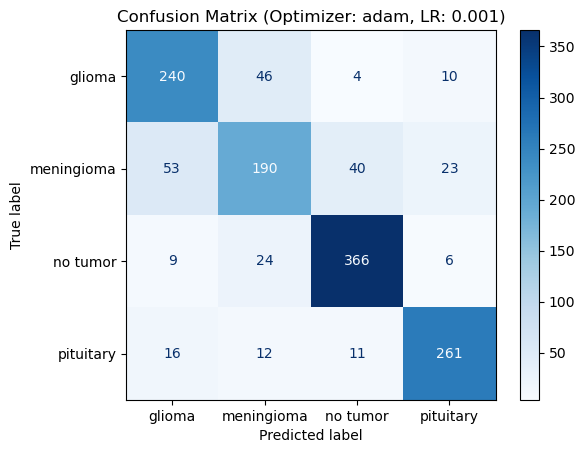

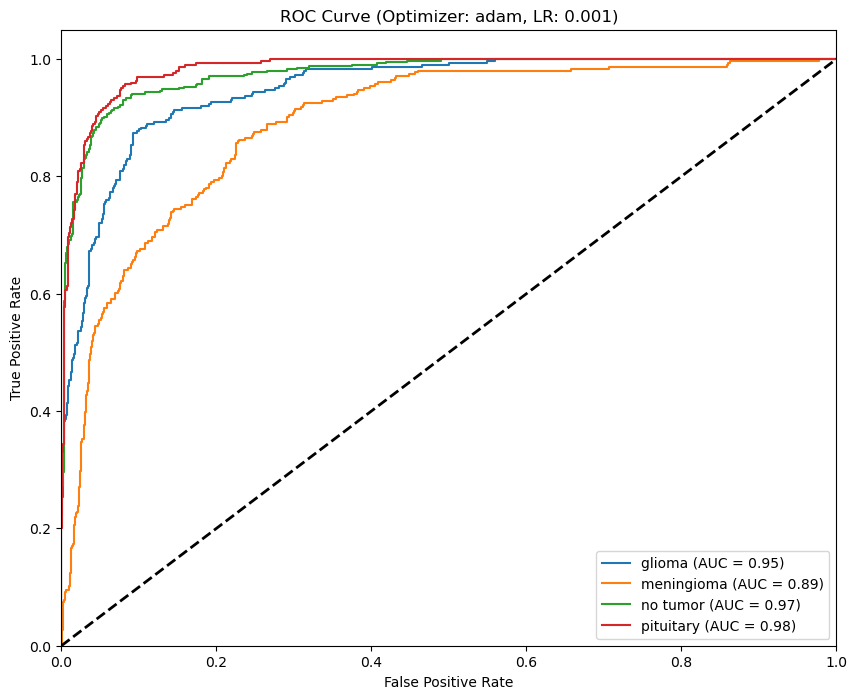

In [71]:
        class_names = ['glioma', 'meningioma', 'no tumor', 'pituitary'] 

        # Evaluate the model and make predictions on the test set
        y_pred = model_new.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)  # Convert one-hot encoded predictions to class labels
        y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded true labels to class labels

        # Generate the confusion matrix
        cm = confusion_matrix(y_true, y_pred_classes)

        # Visualize the confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f"Confusion Matrix (Optimizer: {optimizer_name}, LR: {lr})")
        plt.show()

        # ROC Curve - One-vs-Rest
        y_test_binarized = label_binarize(y_true, classes=np.arange(num_classes))
        
        # Plot ROC curve for each class
        plt.figure(figsize=(10, 8))
        for i in (range(num_classes)):
            fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

        plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for random classifier
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f"ROC Curve (Optimizer: {optimizer_name}, LR: {lr})")
        plt.legend(loc="lower right")
        plt.show()

        # Record the final training and validation accuracy
        final_train_acc = history.history['accuracy'][-1]
        final_val_acc = history.history['val_accuracy'][-1]

last try